# Lab 1: Comparison of the Tensile Properties of the Collateral Ligaments

## Data Analysis

Goals for this lab report:

- **Hypotheses:** What is the effect of the test variable (MCL vs LCL) on
  - Stiffness, $k$
  - Tangent Elastic Modulus, $E$
- Present $\text{mean}\pm\text{std. dev.}$ and perform statistical tests for:
  - Geometric Dimensions: $L_0$, $w$, $t$
  - Cross-sectional area, $A$
  - Stiffness, $k$ (T-Test)
  - Tangend Elastic Modulus, $E$ (T-Test)

In [1]:
# Google Colab: Run this to mount your Google Drive

# from google.colab import drive
# import os
# drive.mount('/content/gdrive', force_remount=True)
# os.chdir('/content/gdrive/MyDrive/BMES 301/Lab 1')

In [2]:
# Notebook setup

%load_ext autoreload
%autoreload 2

## Import necessary libraries
### Data analysis
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import tools
from scipy import stats

### Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

### Setup
from pathlib import Path
import re
import os

## Define the paths to raw data and results
datapath = Path('data')

In [3]:
# Load data

## Regular expression to pull sample and team information from file name
meta = re.compile(r"(?P<tissue>[ml]cl)(?P<team>\d{2})")

## Load all data into a list
data = []
for file in datapath.glob("lab1*.csv"):

    ## Extract sample and team information from file name
    match = meta.search(file.name)

    ## Load data
    try:
        _df = tools.load_data(file)
        _df['tissue'] = match.group('tissue').upper()
        _df['team'] = match.group('team')
        data.append(_df)
    except AssertionError as e:
        print(f"Error loading {file.name}: {e}")

## Concatenate all data into a single dataframe
data = pd.concat(data).reset_index(drop=True)
display(data.head())

## Load specimen dimensions
specimen = pd.read_excel(datapath / 'lab1_specimen_dimensions.xlsx')

,time,disp,load,tissue,team
0,0.0000,-2.000079,-0.08,LCL,01
1,0.1464,-1.998455,-0.08,LCL,01
2,0.2928,-1.995375,-0.08,LCL,01
3,0.4392,-1.984185,-0.08,LCL,01
4,0.5856,-1.970243,-0.08,LCL,01


## Raw Data Visualization

**Preconditioning:** $t > 120s$

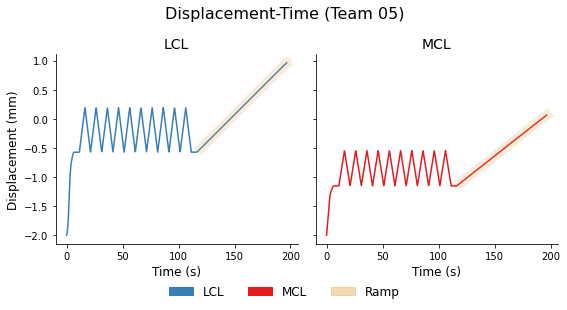

In [4]:
# Disp vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='disp',
    xlab='Time (s)',
    ylab='Displacement (mm)',
    title='Displacement-Time (Team 05)',
    highlight_ramp=True,
    ramp_time=120
)

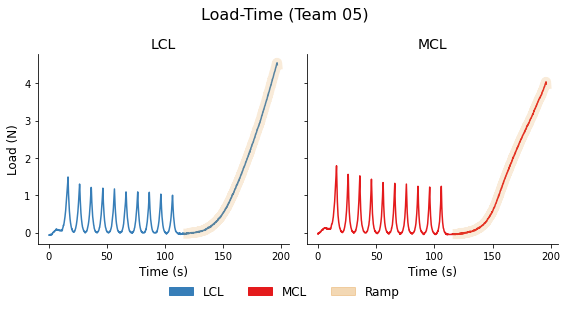

In [5]:
# Load vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='load',
    xlab='Time (s)',
    ylab='Load (N)',
    title='Load-Time (Team 05)',
    highlight_ramp=True,
    ramp_time=120
)

## Visualization: Stress & Strain

$$ \text{Stress, } \sigma = \frac{F}{w \cdot t} $$

$$ \text{Strain, } \varepsilon = \frac{\Delta L}{L_0} $$

Figures from this point only include the 'ramp' data.

In [6]:
# Exclude preconditioning data and shift displacement to start at 0
data = data.loc[data['time'] > 120].copy()

# Shift displacement and time to start at 0 (Done separately for each team)
for team in data['team'].unique():
    I = data['team'] == team
    data.loc[I, 'disp'] = (data.loc[I]
        .groupby('tissue')['disp']
        .apply(lambda x: x - x.iloc[0]))
    data.loc[I, 'time'] = (data.loc[I]
        .groupby('tissue')['time']
        .apply(lambda x: x - x.iloc[0]))

In [7]:
# Compute stress and strain
for team in data['team'].unique():
    for tissue in ['MCL', 'LCL']:
        I = (data['team'] == team) & (data['tissue'] == tissue)
        J = (specimen['Group #'] == int(team)) & (specimen['Ligament'] == tissue)

        # Stress
        A = (specimen.loc[J, 'Width (mm)'] * specimen.loc[J, 'Thickness (mm)']).values[0]
        data.loc[I, 'stress'] = data.loc[I, 'load'] / A

        # Strain
        L0 = specimen.loc[J, 'Gauge length (mm)'].values[0]
        data.loc[I, 'strain'] = data.loc[I, 'disp'] / L0

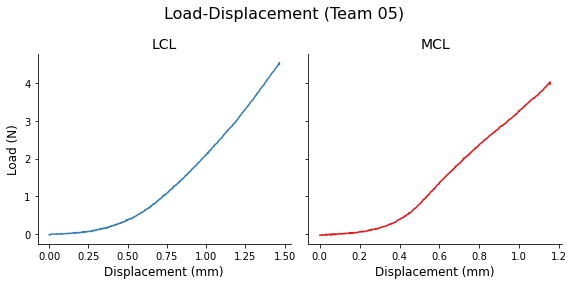

In [8]:
# Load vs Displacement
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='disp',
    yvar='load',
    xlab='Displacement (mm)',
    ylab='Load (N)',
    title='Load-Displacement (Team 05)',
    highlight_ramp=False
)

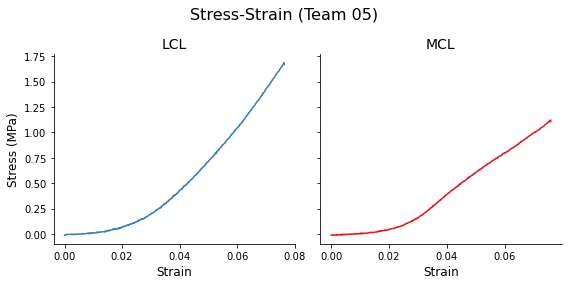

In [9]:
# Stress vs Strain
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='strain',
    yvar='stress',
    xlab='Strain',
    ylab='Stress (MPa)',
    title='Stress-Strain (Team 05)',
    highlight_ramp=False
)

### Weird Data

After looking the Stress-Strain plots for each team, I noticed that there were 
two tests with significant discontinuities at higher stresses.

- Team 09: LCL
- Team 10: MCL

I decided to exculde the discontinuous portion of the data from the curve fit.
In the code cells below, I plot the original data before excluding the points 
from the analysis.

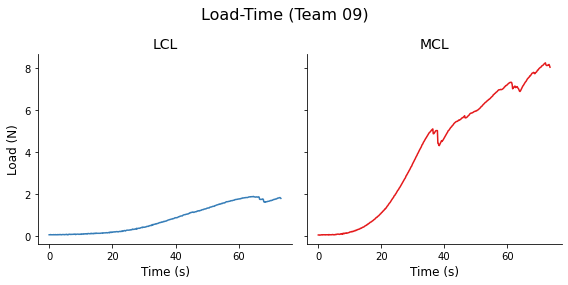

In [10]:
# Load vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='load',
    xlab='Time (s)',
    ylab='Load (N)',
    title='Load-Time (Team 09)',
    team='09'
)

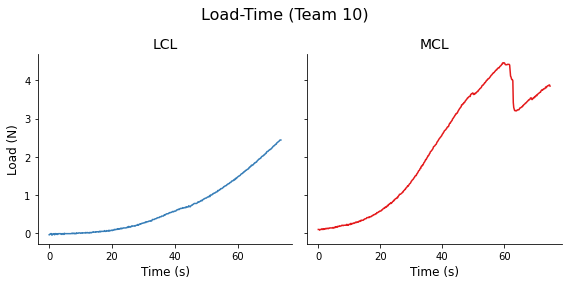

In [11]:
# Load vs Time
fig, ax = tools.plot_data(
    data = data.copy(),
    xvar='time',
    yvar='load',
    xlab='Time (s)',
    ylab='Load (N)',
    title='Load-Time (Team 10)',
    team='10'
)

## Curve Fitting: Estimate $E$ and $k$


$$ \sigma = E \cdot \varepsilon $$
$$ F = k\cdot \Delta L $$
$$ k = \frac{E \cdot A}{L_0} $$

In [17]:
test_data = (data[['tissue', 'team']]
    .drop_duplicates()
    .reset_index(drop=True))

In [21]:
test_data.head()

,tissue,team,E
0,LCL,01,NaN
1,LCL,02,NaN
2,LCL,03,NaN
3,LCL,04,NaN
4,LCL,05,1.0


In [20]:
K = (test_data['tissue'] == 'LCL') & (test_data['team'] == '05')
test_data.loc[K, 'E'] = 1

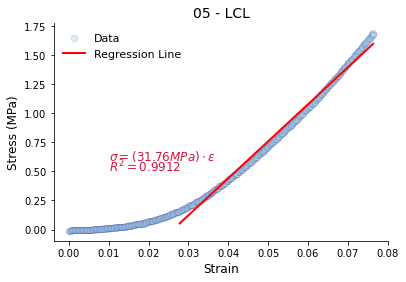

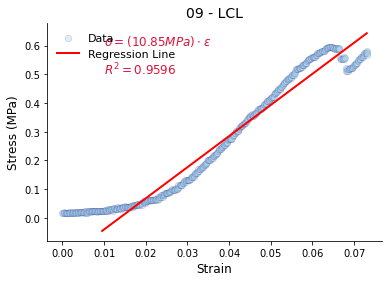

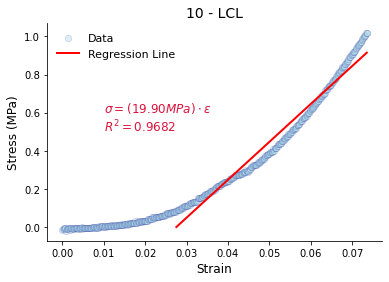

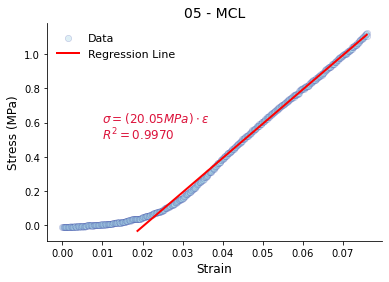

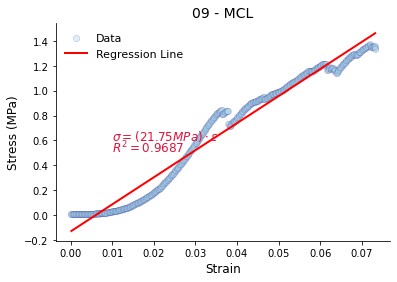

R^2 didn't converge after 40% of the data was removed


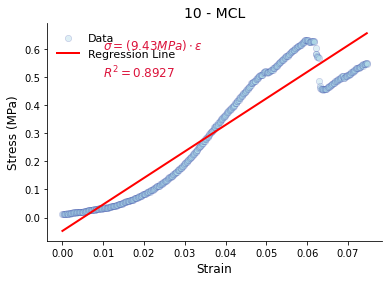

,tissue,team,E,k
0,LCL,01,12.114833,4.330408
1,LCL,02,4.833454,1.325463
2,LCL,03,13.323036,4.946177
3,LCL,04,21.076802,2.965674
4,LCL,05,31.760841,4.466368
5,LCL,06,2.264104,0.306997
6,LCL,07,9.168397,1.384132
7,LCL,08,10.227016,1.363602
8,LCL,09,10.849173,2.608771
9,LCL,10,19.895183,4.504570


In [26]:
# Create new dataframe to store results
test_data = (data[['tissue', 'team']]
    .drop_duplicates()
    .reset_index(drop=True))

for tissue in ['LCL', 'MCL']:
    for team in data['team'].unique():
        # Subset data
        I = (data['team'] == team) & (data['tissue'] == tissue)
        _data = data.loc[I].copy()

        # Find linear region
        i, _ = tools.get_linear_region(_data)

        # Fit linear model
        mdl = smf.ols('stress ~ strain', data=_data[i:]).fit()

        # Compute tissue properties
        J = (specimen['Group #'] == int(team)) & (specimen['Ligament'] == tissue)

        ## Elastic Modulus = Slope
        E = mdl.params['strain']  ## MPa

        # Stiffness = Slope * Area / Gauge Length
        A = (specimen.loc[J, 'Width (mm)'] * specimen.loc[J, 'Thickness (mm)']).values[0]
        L0 = specimen.loc[J, 'Gauge length (mm)'].values[0]
        k = E * A / L0  ## N/mm

        # Plot
        if team in ['05', '09', '10']:
            fig, ax = tools.plot_regression(_data, mdl, i, f'{team} - {tissue}')
            plt.show() 

        # Store results
        K = (test_data['tissue'] == tissue) & (test_data['team'] == team)
        test_data.loc[K, 'E'] = E
        test_data.loc[K, 'k'] = k       

# Display and save results
test_data.to_excel(datapath / 'lab1_test_data.xlsx');
display(test_data)

In [33]:
# T-Test to Compare LCL and MCL
## Assumptions:
### 1. Normality
### 2. Equal Variance
### 3. Independent Samples


ttest = stats.ttest_ind(
    test_data.loc[test_data['tissue'] == 'MCL', ['E', 'k']].values,
    test_data.loc[test_data['tissue'] == 'LCL', ['E', 'k']].values,
    axis=0
)
print(f"""
T-Test Results:
    E: t = {ttest[0][0]:.4f}, p = {ttest[1][0]:.4f}
    k: t = {ttest[0][1]:.4f}, p = {ttest[1][1]:.4f}
""")


T-Test Results:
    E: t = 0.4057, p = 0.6898
    k: t = 1.7438, p = 0.0982

